In [1]:
# Importing necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D
from tensorflow.keras import layers

In [2]:
# Costumizing Image size, batch size, and Channels
IMAGE_SIZE = 128
BATCH_SIZE = 16
CHANNELS = 3

In [3]:
# Loading Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\F2076TU\Downloads\Plant_Village\PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 20638 files belonging to 15 classes.


In [4]:
# All the various classes of plant diseases available in dataset
classes = dataset.class_names
classes

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)     # It has created 1290 batches of size 16

1290

In [6]:
# Image shape and batch size with batch labels.
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 128, 128, 3)
[11  1  1  8  7  0  6 12 11 12 14  9 12  7 12  0]


Data Processing

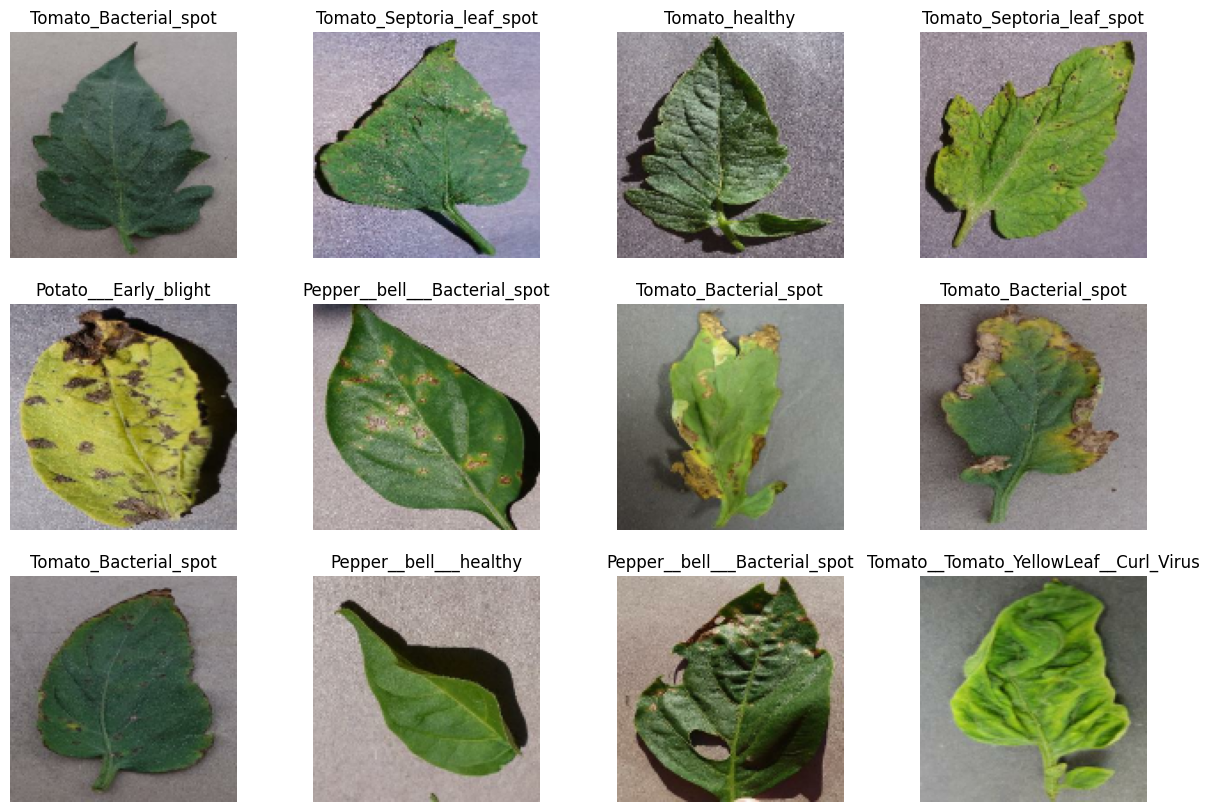

In [7]:
# Showcasing Images with their respective class names
plt.figure(figsize = (15, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [8]:
train_size = 0.8
len(dataset) * train_size

1032.0

In [9]:
train_ds = dataset.take(516)
len(train_ds)

516

In [10]:
test_ds = dataset.skip(516)
len(test_ds)

774

In [11]:
val_size = 0.10
len(dataset) * val_size

129.0

In [12]:
val_ds = test_ds.take(64)
len(val_ds)

64

Data Splitting.

In [13]:
# If above partition/ splitting is not understandable create this function.
# This is proper way of splitting the dataset into train, test and validation data.
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_size = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

1032

In [16]:
len(test_ds)

129

In [17]:
len(val_ds)

129

In [18]:
# Caching elements, shuffling them, and then prefetching the data to optimize the training process by overlapping data preprocessing and model execution.
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)

Model Creation

In [19]:
# Resizing and Reshaping Images in dataset
resize_and_rescale = Sequential([
    layers.Resizing(128, 128),
    layers.Rescaling(1./255)])

In [20]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)])

In [21]:
# Full model creation.
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = 15

model = Sequential([
    resize_and_rescale,
    data_augmentation,
    # Input layer and first Hidden layer
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    # Second Hidden layer
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    # Third Hidden layer
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    # Fourth Hidden layer
    layers.Flatten(),
    # Fifth Hidden layer
    layers.Dense(64, activation = 'relu'),
    # Output layer
    layers.Dense(num_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

C:\Users\F2076TU\venvpd\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (16, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 126, 126, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 63, 63, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 61, 61, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 15)               │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 860,175 (3.28 MB)

 Trainable params: 860,175 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compiling model
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [24]:
# Model Training
history = model.fit(train_ds, epochs = 50, batch_size = 16, verbose = 1, validation_data = val_ds)

Epoch 1/50
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 188s 137ms/step - accuracy: 0.4005 - loss: 1.8772 - val_accuracy: 0.7398 - val_loss: 0.7633
Epoch 2/50
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 103s 99ms/step - accuracy: 0.7343 - loss: 0.7944 - val_accuracy: 0.7471 - val_loss: 0.7042
Epoch 3/50
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - accuracy: 0.8106 - loss: 0.5749 - val_accuracy: 0.7689 - val_loss: 0.7279
Epoch 4/50
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 78s 75ms/step - accuracy: 0.8387 - loss: 0.4864 - val_accuracy: 0.8319 - val_loss: 0.5321
Epoch 5/50
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.8570 - loss: 0.4161 - val_accuracy: 0.8377 - val_loss: 0.5116
Epoch 6/50
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 89s 87ms/step - accuracy: 0.8741 - loss: 0.3665 - val_accuracy: 0.8861 - val_loss: 0.3275
Epoch 7/50
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.8903 - loss: 0.3274 - val_accuracy: 0.8837 - val_loss: 0.3329
Epoch 8/50
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 79s 76ms/step - accuracy: 0.896

In [25]:
# Test Evaluation
test_evaluation = model.evaluate(test_ds, batch_size = BATCH_SIZE)

129/129 ━━━━━━━━━━━━━━━━━━━━ 85s 67ms/step - accuracy: 0.9785 - loss: 0.0643


In [26]:
test_evaluation

[0.07378817349672318, 0.9733527302742004]

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 1032}

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [29]:
# Plotting Accuracies
history.history['accuracy']

[0.5502119660377502,
 0.7564506530761719,
 0.812356173992157,
 0.8421562910079956,
 0.8615990281105042,
 0.8754693865776062,
 0.8857056498527527,
 0.8917019963264465,
 0.9026650786399841,
 0.9110841751098633,
 0.918352484703064,
 0.9222289323806763,
 0.9235614538192749,
 0.9328286051750183,
 0.9294973015785217,
 0.9330708384513855,
 0.9365838766098022,
 0.9368261694908142,
 0.9425802826881409,
 0.9445790648460388,
 0.9428225159645081,
 0.9466384053230286,
 0.9510599374771118,
 0.9507571458816528,
 0.9509388208389282,
 0.9523925185203552,
 0.9538461565971375,
 0.95566326379776,
 0.9574803113937378,
 0.9561477899551392,
 0.9560872316360474,
 0.9588733911514282,
 0.9624469876289368,
 0.9642035365104675,
 0.9599030613899231,
 0.9611144661903381,
 0.9628710150718689,
 0.9652937650680542,
 0.963355541229248,
 0.9676559567451477,
 0.9676559567451477,
 0.966565728187561,
 0.9677771329879761,
 0.9680799245834351,
 0.9691702127456665,
 0.9684433937072754,
 0.9642035365104675,
 0.9691702127456665

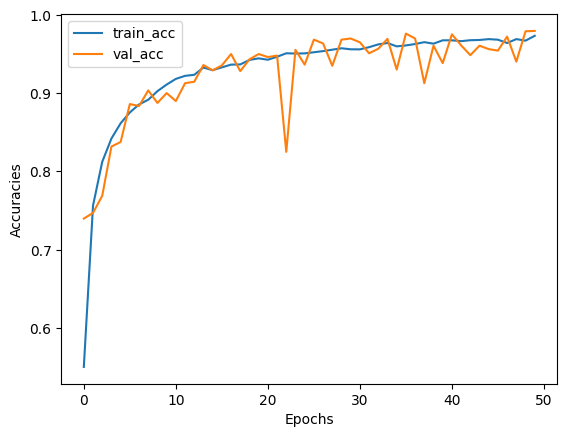

In [30]:
# plotting Train and val Accuracies
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.show()

In [31]:
# Plotting Losses
history.history['loss']

[1.4095451831817627,
 0.7312502861022949,
 0.5598732233047485,
 0.46992990374565125,
 0.4055721163749695,
 0.3603585362434387,
 0.3374158442020416,
 0.3161754906177521,
 0.28083348274230957,
 0.26469340920448303,
 0.2490062564611435,
 0.23366287350654602,
 0.22774294018745422,
 0.20454631745815277,
 0.19998988509178162,
 0.19969165325164795,
 0.186959907412529,
 0.19101661443710327,
 0.17434866726398468,
 0.16771897673606873,
 0.16800355911254883,
 0.15984386205673218,
 0.14687681198120117,
 0.14851582050323486,
 0.1459512859582901,
 0.1398896723985672,
 0.13821937143802643,
 0.13288654386997223,
 0.12531942129135132,
 0.12659040093421936,
 0.13052265346050262,
 0.12055454403162003,
 0.11245860159397125,
 0.10602910816669464,
 0.12164563685655594,
 0.11034151166677475,
 0.11129991710186005,
 0.1073722168803215,
 0.10778480023145676,
 0.0935710221529007,
 0.10288343578577042,
 0.10005751252174377,
 0.10217942297458649,
 0.09868592023849487,
 0.09138467907905579,
 0.09819517284631729,
 0

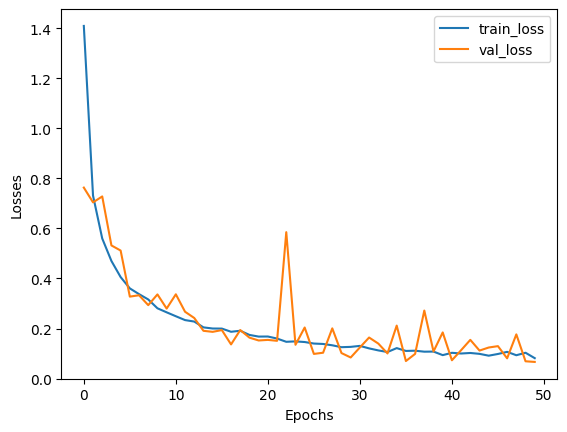

In [32]:
# plotting train and val losses
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.show()

first image to predict
actual label: Tomato_Spider_mites_Two_spotted_spider_mite
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
predicted label: Tomato_Spider_mites_Two_spotted_spider_mite


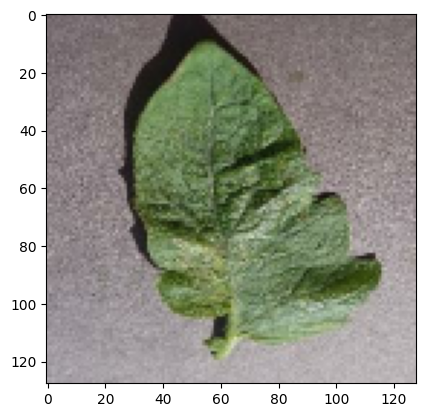

In [33]:
# Predicting Actual label and Prediction label using model
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label:', classes[np.argmax(batch_prediction[0])])

In [34]:
# Creating function to predict image with predicted label and confidence level.
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


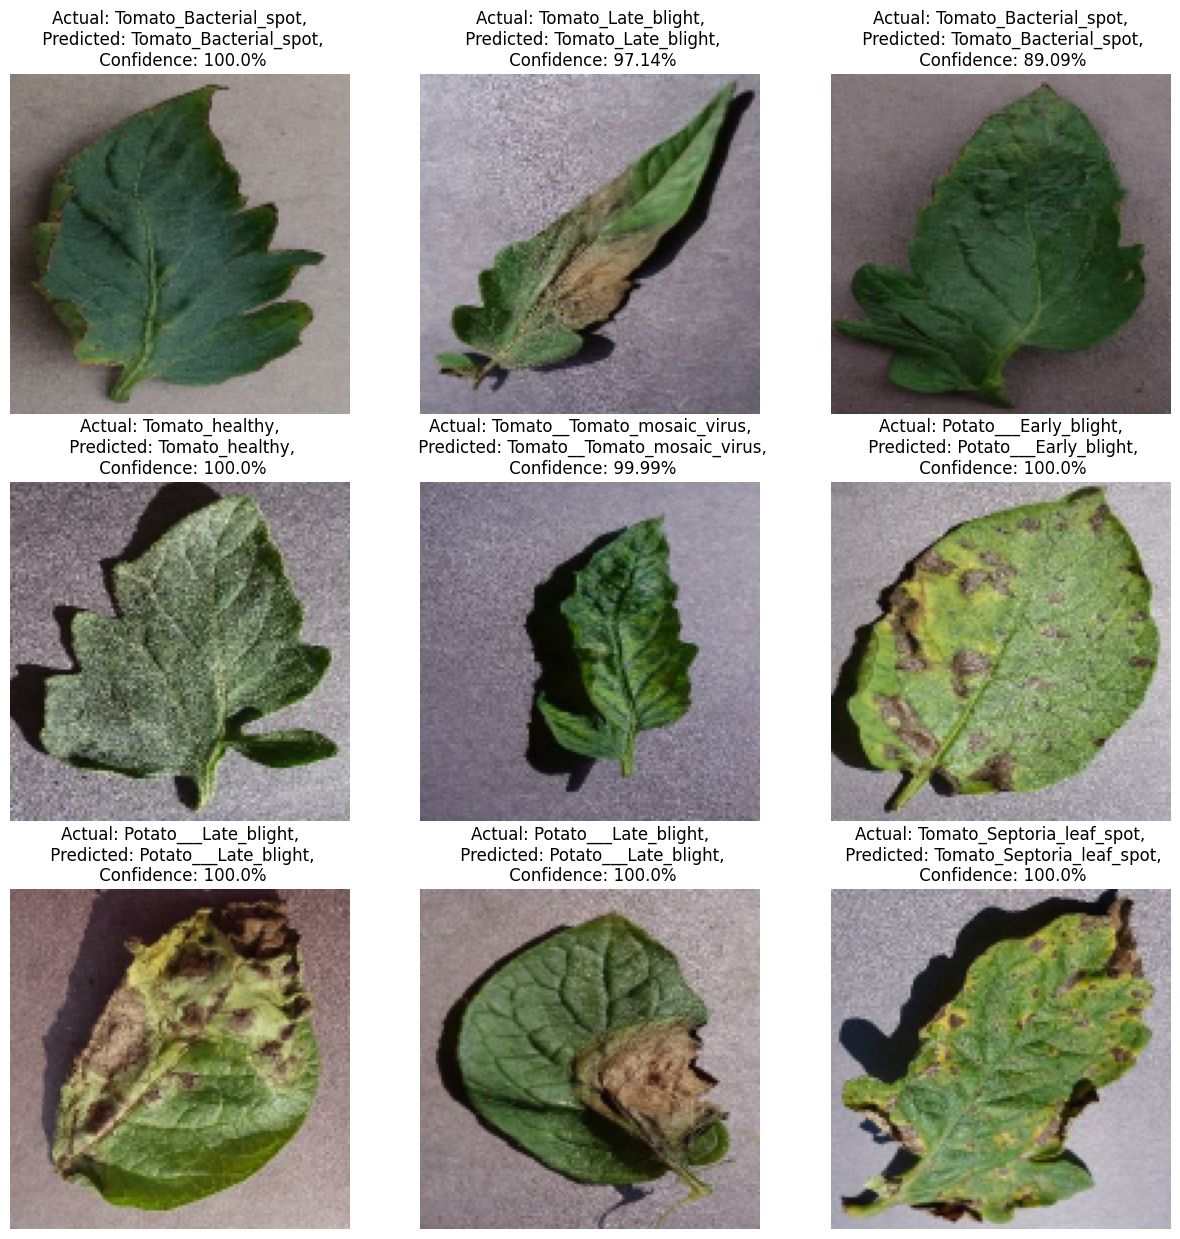

In [35]:
# Prediction of Image with actual label, prediction label and Confidence level
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis('off')

In [42]:
# Save Model in your Directory.
model.save('plant_model_version.keras')